# EWC

$$
\mathcal{L} = 
$$

In [1]:
%load_ext autoreload
%autoreload 2

# Libraries

In [2]:
import pickle
from tqdm import tqdm

In [3]:
from avalanche.benchmarks.classic import PermutedMNIST
from avalanche.models import SimpleMLP
from avalanche.training import EWC
from avalanche.training.plugins import EvaluationPlugin
from avalanche.logging import InteractiveLogger
from avalanche.evaluation.metrics import (
    accuracy_metrics,
    bwt_metrics,
    confusion_matrix_metrics,
    forgetting_metrics,
    timing_metrics,
    cpu_usage_metrics,
    gpu_usage_metrics,
    disk_usage_metrics,
    ram_usage_metrics,
    loss_metrics,
    class_accuracy_metrics,
    accuracy_matrix_metrics
)

from torch.nn import CrossEntropyLoss
from torch.optim import SGD
from torch import cuda

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Custom Libraries

In [4]:
import sys

sys.path.append("../base_code/")

from base_code.constants import DATASETS_PATH, SAVED_METRICS_PATH
from base_code.plugins import WeightStoragePlugin

# Constants

In [5]:
TORCH_DEVICE = "cuda" if cuda.is_available() else "cpu"
N_EXPERIENCES = 10
EXPERIMENT_SEED = 1234
METRICS_SUBFOLDER = "standard"
METRICS_FILENAME = f"{METRICS_SUBFOLDER}/ewc.pkl"

# Dataset and definitions

## Dataset loading

We load state-of-the-art dataset Modified NIST

In [6]:
scenario = PermutedMNIST(N_EXPERIENCES, seed=EXPERIMENT_SEED, dataset_root=DATASETS_PATH)

## Scenario creation with train test streaming

In this point, we define our scenario considering a training where in every experience of it, a new class is presented. This is, first we train with a class $a$, the following experience we train with class $b$ ($a \neq b$)

In [7]:
train_stream = scenario.train_stream
test_stream = scenario.test_stream

# Model Selection

In [8]:
from math import floor
from itertools import product
from typing import List

# Constants
MODEL_SELECTION_MAX_EXPERIENCES = floor(N_EXPERIENCES * 0.2)

strategy_hyperparameters_grid = {
    "ewc_lambda": [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0],
}

# Create the models
models = [
    SimpleMLP(num_classes=scenario.n_classes, hidden_size=100, input_size=28 * 28).to(TORCH_DEVICE)
    for _ in product(*strategy_hyperparameters_grid.values())
]
hyperparameters_product = list(product(*strategy_hyperparameters_grid.values()))

strategies: List[EWC] = []
for model, hyperparameters in zip(models, hyperparameters_product):
    strategy = EWC(
        model,
        SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005),
        CrossEntropyLoss(),
        train_mb_size=100,
        train_epochs=1,
        eval_mb_size=100,
        device=TORCH_DEVICE,
        evaluator=EvaluationPlugin(
            accuracy_metrics(
                stream=True
            ),
        ),
        **dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters)),
    )
    strategies.append(strategy)

# train each model on the first 20% of the experiences
for i, strategy in enumerate(strategies):
    print(f"Training model {i + 1}/{len(strategies)}")
    for experience in train_stream[:MODEL_SELECTION_MAX_EXPERIENCES]:
        strategy.train(experience)
    strategy.eval(train_stream[:MODEL_SELECTION_MAX_EXPERIENCES])


/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/training/plugins/evaluation.py:94: UserWarning: No loggers specified, metrics will not be logged
  warnings.warn("No loggers specified, metrics will not be logged")


Training model 1/7
Training model 2/7
Training model 3/7
Training model 4/7
Training model 5/7
Training model 6/7
Training model 7/7


In [9]:
# Get the model with the best averaged accuracy
best_hyperparameters_idx = -1
best_avg_accuracy = 0

for i, strategy in enumerate(strategies):
    avg_accuracy = strategy.evaluator.get_last_metrics()["Top1_Acc_Stream/eval_phase/train_stream/Task000"]
    if avg_accuracy > best_avg_accuracy:
        best_avg_accuracy = avg_accuracy
        best_hyperparameters_idx = i

best_hyperparameters = dict(zip(strategy_hyperparameters_grid.keys(), hyperparameters_product[best_hyperparameters_idx]))

In [10]:
best_hyperparameters

{'ewc_lambda': 50.0}

## Evaluation metrics definition

In [11]:
eval_plugin = EvaluationPlugin(
    accuracy_metrics(experience=True, stream=True),
    loss_metrics(minibatch=True, experience=True, stream=True),
    timing_metrics(epoch=True, epoch_running=True),
    cpu_usage_metrics(minibatch=True, experience=True, stream=True),
    gpu_usage_metrics(experience=True, stream=True, gpu_id=TORCH_DEVICE),
    disk_usage_metrics(experience=True, stream=True),
    ram_usage_metrics(experience=True, stream=True),
    class_accuracy_metrics(experience=True, stream=True),
    accuracy_matrix_metrics(),
    forgetting_metrics(experience=True, stream=True),
    bwt_metrics(experience=True, stream=True),
    confusion_matrix_metrics(stream=True, num_classes=scenario.n_classes),
    
    loggers=[InteractiveLogger()]
)

/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")
/Users/jesusoyanedelespinoza/.pyenv/versions/3.9.18/envs/tt2/lib/python3.9/site-packages/avalanche/evaluation/metrics/gpu_usage.py:56: UserWarning: Your system has no GPU!
  warnings.warn("Your system has no GPU!")


## Plugin defitinitions

In [12]:
model_plugins = [WeightStoragePlugin()]

## Model, Optimizer, Loss function and Strategy definition

* `model`: Multi Layer Perceptron
* `Optimizer`: Adam
* `Loss function`: Cross Entropy
* `Strategy`: Elastic Weight Consolidation

In [13]:
model = SimpleMLP(num_classes=scenario.n_classes, input_size=28 * 28, hidden_layers=2, hidden_size=100).to(TORCH_DEVICE)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0005)
criterion = CrossEntropyLoss().to(TORCH_DEVICE)
strategy = EWC(
    model,
    optimizer,
    criterion,
    train_epochs=5,
    train_mb_size=128,
    plugins=model_plugins,
    evaluator=eval_plugin,
    eval_mb_size=128,
    device=TORCH_DEVICE,
    **best_hyperparameters
)

# Training and evaluation

Revisar porque el entrenamiento se está comportando de forma rara

  0%|          | 0/10 [00:00<?, ?it/s]

-- >> Start of training phase << --
100%|██████████| 469/469 [00:04<00:00, 115.60it/s]
Epoch 0 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 113.6000
	Loss_MB/train_phase/train_stream/Task000 = 1.1314
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.0575
100%|██████████| 469/469 [00:04<00:00, 113.02it/s]
Epoch 1 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 106.5000
	Loss_MB/train_phase/train_stream/Task000 = 0.7499
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.1495
100%|██████████| 469/469 [00:04<00:00, 113.63it/s]
Epoch 2 ended.
	CPUUsage_MB/train_phase/train_stream/Task000 = 112.3000
	Loss_MB/train_phase/train_stream/Task000 = 0.7146
	RunningTime_Epoch/train_phase/train_stream/Task000 = 0.0000
	Time_Epoch/train_phase/train_stream/Task000 = 4.1277
100%|██████████| 469/469 [00:04<00:00, 115.60it/s]
Epoch 3 ended.
	CPUUsage_MB/train_phase/train_

 10%|█         | 1/10 [00:32<04:56, 32.96s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.8125
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14f3a2dc0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4974.0000
	EvalStream/Acc_Matrix = 
tensor([[0.9126, 0.1230, 0.1445, 0.1285, 0.1426, 0.0807, 0.1211, 0.1021, 0.1361,
         0.1240],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 20%|██        | 2/10 [01:08<04:36, 34.59s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.5744
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14fb29e80>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4974.0000
	EvalStream/Acc_Matrix = 
tensor([[0.9126, 0.1230, 0.1445, 0.1285, 0.1426, 0.0807, 0.1211, 0.1021, 0.1361,
         0.1240],
        [0.9020, 0.9233, 0.1345, 0.1042, 0.1415, 0.0781, 0.0933, 0.1136, 0.1298,
         0.1597],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 30%|███       | 3/10 [01:45<04:10, 35.72s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.7869
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14fe77070>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4974.0000
	EvalStream/Acc_Matrix = 
tensor([[0.9126, 0.1230, 0.1445, 0.1285, 0.1426, 0.0807, 0.1211, 0.1021, 0.1361,
         0.1240],
        [0.9020, 0.9233, 0.1345, 0.1042, 0.1415, 0.0781, 0.0933, 0.1136, 0.1298,
         0.1597],
        [0.8943, 0.8971, 0.9285, 0.0917, 0.1252, 0.1021, 0.0848, 0.1404, 0.1056,
         0.1244],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 40%|████      | 4/10 [02:25<03:43, 37.23s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.2400
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x166b2f940>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4974.0000
	EvalStream/Acc_Matrix = 
tensor([[0.9126, 0.1230, 0.1445, 0.1285, 0.1426, 0.0807, 0.1211, 0.1021, 0.1361,
         0.1240],
        [0.9020, 0.9233, 0.1345, 0.1042, 0.1415, 0.0781, 0.0933, 0.1136, 0.1298,
         0.1597],
        [0.8943, 0.8971, 0.9285, 0.0917, 0.1252, 0.1021, 0.0848, 0.1404, 0.1056,
         0.1244],
        [0.8746, 0.8869, 0.9063, 0.9276, 0.1079, 0.0617, 0.0947, 0.1446, 0.0934,
         0.1186],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 50%|█████     | 5/10 [03:06<03:13, 38.70s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.4733
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x166d13e80>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4974.0000
	EvalStream/Acc_Matrix = 
tensor([[0.9126, 0.1230, 0.1445, 0.1285, 0.1426, 0.0807, 0.1211, 0.1021, 0.1361,
         0.1240],
        [0.9020, 0.9233, 0.1345, 0.1042, 0.1415, 0.0781, 0.0933, 0.1136, 0.1298,
         0.1597],
        [0.8943, 0.8971, 0.9285, 0.0917, 0.1252, 0.1021, 0.0848, 0.1404, 0.1056,
         0.1244],
        [0.8746, 0.8869, 0.9063, 0.9276, 0.1079, 0.0617, 0.0947, 0.1446, 0.0934,
         0.1186],
        [0.8781, 0.8894, 0.8831, 0.8786, 0.9273, 0.0871, 0.0794, 0.1421, 0.1218,
         0.1318],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 60%|██████    | 6/10 [03:49<02:40, 40.18s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 105.3602
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x166fda4f0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4974.0000
	EvalStream/Acc_Matrix = 
tensor([[0.9126, 0.1230, 0.1445, 0.1285, 0.1426, 0.0807, 0.1211, 0.1021, 0.1361,
         0.1240],
        [0.9020, 0.9233, 0.1345, 0.1042, 0.1415, 0.0781, 0.0933, 0.1136, 0.1298,
         0.1597],
        [0.8943, 0.8971, 0.9285, 0.0917, 0.1252, 0.1021, 0.0848, 0.1404, 0.1056,
         0.1244],
        [0.8746, 0.8869, 0.9063, 0.9276, 0.1079, 0.0617, 0.0947, 0.1446, 0.0934,
         0.1186],
        [0.8781, 0.8894, 0.8831, 0.8786, 0.9273, 0.0871, 0.0794, 0.1421, 0.1218,
         0.1318],
        [0.8702, 0.8807, 0.8445, 0.8523, 0.8956, 0.9275, 0.0797, 0.1877, 0.1107,
         0.1050],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
    

 70%|███████   | 7/10 [04:32<02:03, 41.18s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 102.6665
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x1685413a0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4974.0000
	EvalStream/Acc_Matrix = 
tensor([[0.9126, 0.1230, 0.1445, 0.1285, 0.1426, 0.0807, 0.1211, 0.1021, 0.1361,
         0.1240],
        [0.9020, 0.9233, 0.1345, 0.1042, 0.1415, 0.0781, 0.0933, 0.1136, 0.1298,
         0.1597],
        [0.8943, 0.8971, 0.9285, 0.0917, 0.1252, 0.1021, 0.0848, 0.1404, 0.1056,
         0.1244],
        [0.8746, 0.8869, 0.9063, 0.9276, 0.1079, 0.0617, 0.0947, 0.1446, 0.0934,
         0.1186],
        [0.8781, 0.8894, 0.8831, 0.8786, 0.9273, 0.0871, 0.0794, 0.1421, 0.1218,
         0.1318],
        [0.8702, 0.8807, 0.8445, 0.8523, 0.8956, 0.9275, 0.0797, 0.1877, 0.1107,
         0.1050],
        [0.8665, 0.8605, 0.8412, 0.8161, 0.8451, 0.8590, 0.9292, 0.1456, 0.1102,
         0.1451],
    

 80%|████████  | 8/10 [05:21<01:26, 43.47s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.8116
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x16910feb0>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4974.0000
	EvalStream/Acc_Matrix = 
tensor([[0.9126, 0.1230, 0.1445, 0.1285, 0.1426, 0.0807, 0.1211, 0.1021, 0.1361,
         0.1240],
        [0.9020, 0.9233, 0.1345, 0.1042, 0.1415, 0.0781, 0.0933, 0.1136, 0.1298,
         0.1597],
        [0.8943, 0.8971, 0.9285, 0.0917, 0.1252, 0.1021, 0.0848, 0.1404, 0.1056,
         0.1244],
        [0.8746, 0.8869, 0.9063, 0.9276, 0.1079, 0.0617, 0.0947, 0.1446, 0.0934,
         0.1186],
        [0.8781, 0.8894, 0.8831, 0.8786, 0.9273, 0.0871, 0.0794, 0.1421, 0.1218,
         0.1318],
        [0.8702, 0.8807, 0.8445, 0.8523, 0.8956, 0.9275, 0.0797, 0.1877, 0.1107,
         0.1050],
        [0.8665, 0.8605, 0.8412, 0.8161, 0.8451, 0.8590, 0.9292, 0.1456, 0.1102,
         0.1451],
    

 90%|█████████ | 9/10 [06:07<00:44, 44.37s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.9532
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14b886c40>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4974.0000
	EvalStream/Acc_Matrix = 
tensor([[0.9126, 0.1230, 0.1445, 0.1285, 0.1426, 0.0807, 0.1211, 0.1021, 0.1361,
         0.1240],
        [0.9020, 0.9233, 0.1345, 0.1042, 0.1415, 0.0781, 0.0933, 0.1136, 0.1298,
         0.1597],
        [0.8943, 0.8971, 0.9285, 0.0917, 0.1252, 0.1021, 0.0848, 0.1404, 0.1056,
         0.1244],
        [0.8746, 0.8869, 0.9063, 0.9276, 0.1079, 0.0617, 0.0947, 0.1446, 0.0934,
         0.1186],
        [0.8781, 0.8894, 0.8831, 0.8786, 0.9273, 0.0871, 0.0794, 0.1421, 0.1218,
         0.1318],
        [0.8702, 0.8807, 0.8445, 0.8523, 0.8956, 0.9275, 0.0797, 0.1877, 0.1107,
         0.1050],
        [0.8665, 0.8605, 0.8412, 0.8161, 0.8451, 0.8590, 0.9292, 0.1456, 0.1102,
         0.1451],
    

100%|██████████| 10/10 [06:54<00:00, 41.49s/it]

-- >> End of eval phase << --
	CPUUsage_Stream/eval_phase/test_stream/Task000 = 104.9386
	ConfusionMatrix_Stream/eval_phase/test_stream = <avalanche.evaluation.metric_results.AlternativeValues object at 0x14bc4dc70>
	DiskUsage_Stream/eval_phase/test_stream/Task000 = 4974.0000
	EvalStream/Acc_Matrix = 
tensor([[0.9126, 0.1230, 0.1445, 0.1285, 0.1426, 0.0807, 0.1211, 0.1021, 0.1361,
         0.1240],
        [0.9020, 0.9233, 0.1345, 0.1042, 0.1415, 0.0781, 0.0933, 0.1136, 0.1298,
         0.1597],
        [0.8943, 0.8971, 0.9285, 0.0917, 0.1252, 0.1021, 0.0848, 0.1404, 0.1056,
         0.1244],
        [0.8746, 0.8869, 0.9063, 0.9276, 0.1079, 0.0617, 0.0947, 0.1446, 0.0934,
         0.1186],
        [0.8781, 0.8894, 0.8831, 0.8786, 0.9273, 0.0871, 0.0794, 0.1421, 0.1218,
         0.1318],
        [0.8702, 0.8807, 0.8445, 0.8523, 0.8956, 0.9275, 0.0797, 0.1877, 0.1107,
         0.1050],
        [0.8665, 0.8605, 0.8412, 0.8161, 0.8451, 0.8590, 0.9292, 0.1456, 0.1102,
         0.1451],
    

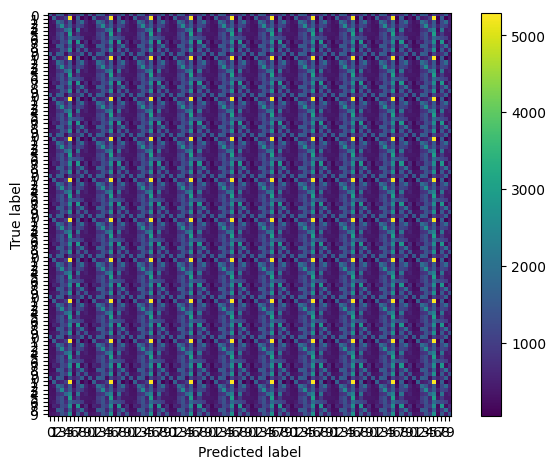

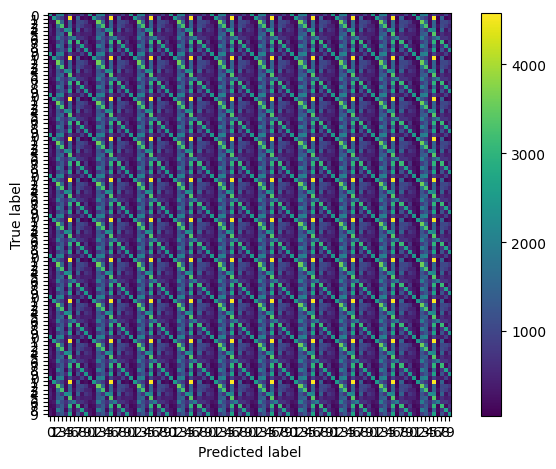

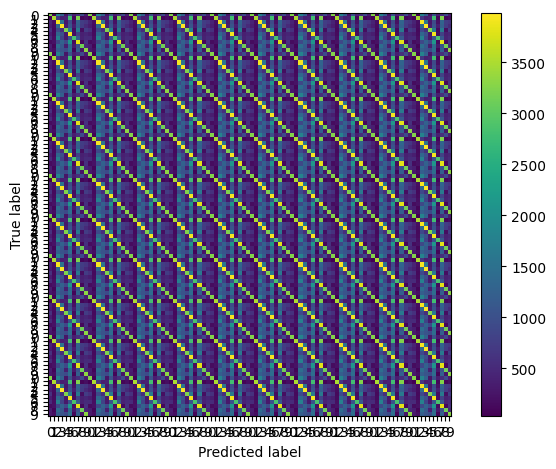

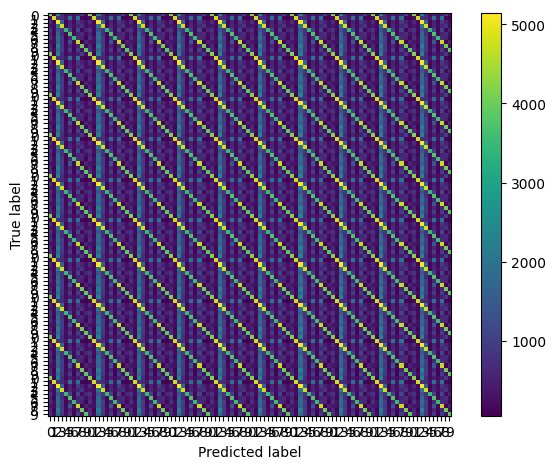

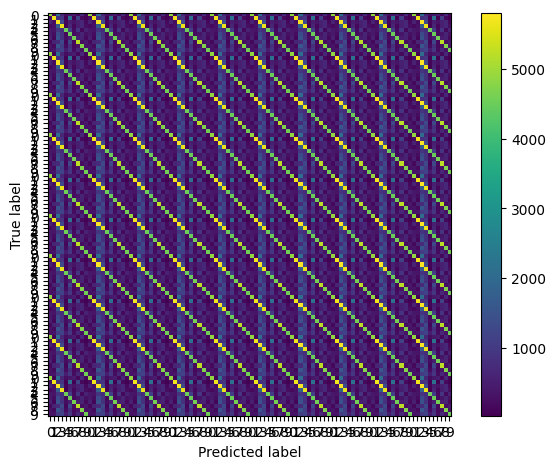

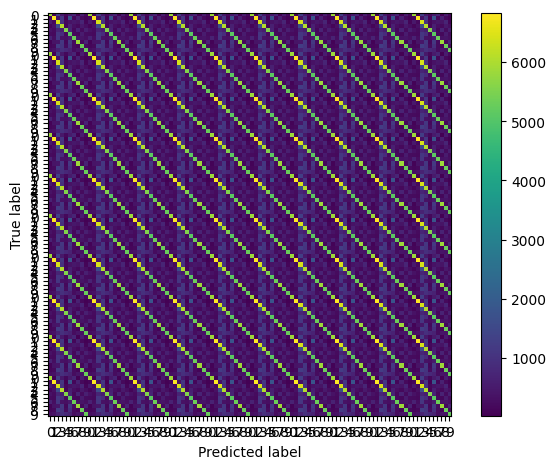

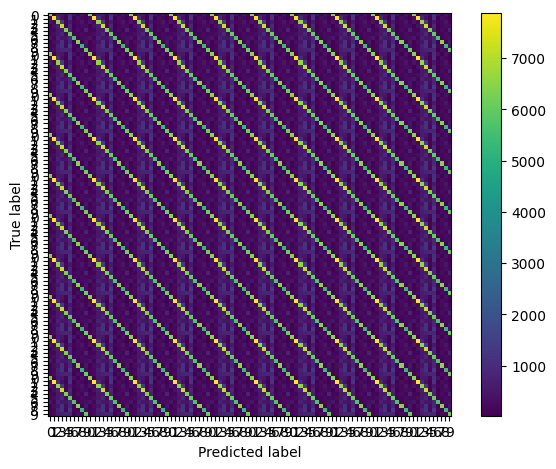

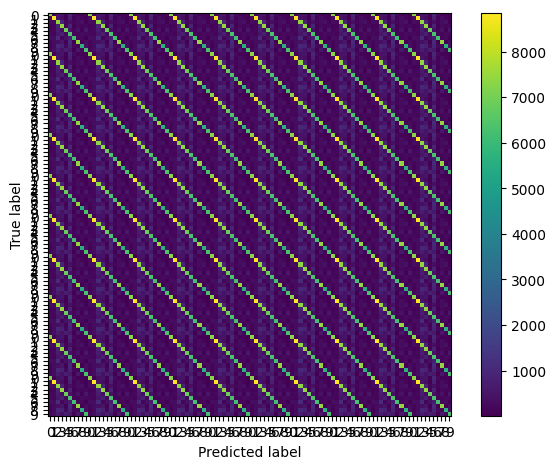

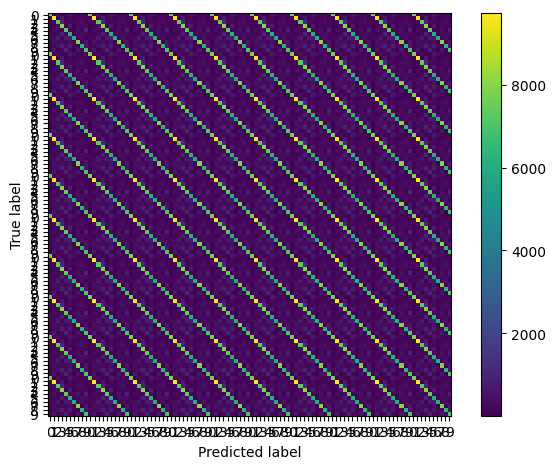

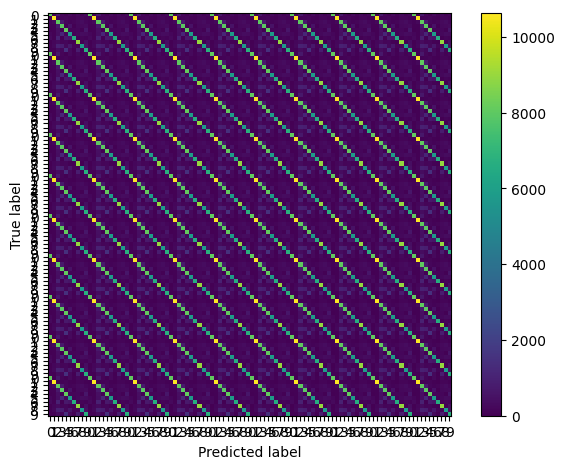

In [14]:
for experience in tqdm(train_stream):
    strategy.train(experience)
    strategy.eval(test_stream)

# Get metrics

In [15]:
accuracies: dict[int, list[float]] = dict()
forgettings: dict[int, list[float]] = dict()
bwt: dict[int, list[float]] = dict()
class_accuracies: dict[int, list[float]] = dict()
losses: dict[int, list[float]] = dict()

for i in range(N_EXPERIENCES):
    filled_i = str(i).zfill(3)
    accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_Acc_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    forgettings[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceForgetting/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    bwt[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"ExperienceBWT/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
    class_accuracies[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Top1_ClassAcc_Stream/eval_phase/test_stream/Task000/{i}"
    ][1]
    losses[f"Task{i}"] = eval_plugin.get_all_metrics()[
        f"Loss_Exp/eval_phase/test_stream/Task000/Exp{filled_i}"
    ][1]
        

accuracies["Overall"] = eval_plugin.get_all_metrics()[
    "Top1_Acc_Stream/eval_phase/test_stream/Task000"
][1]

In [16]:
train_cpu_usage = eval_plugin.get_all_metrics()["CPUUsage_MB/train_phase/train_stream/Task000"][1]
train_time_epoch = eval_plugin.get_all_metrics()["Time_Epoch/train_phase/train_stream/Task000"][1]
train_running_time = eval_plugin.get_all_metrics()["RunningTime_Epoch/train_phase/train_stream/Task000"][1]
train_loss_epoch = eval_plugin.get_all_metrics()["Loss_MB/train_phase/train_stream/Task000"][1]

In [17]:
weights = model_plugins[0].weights

# Store metrics

In [18]:
pickle.dump({
    "accuracies": accuracies,
    "forgettings": forgettings,
    "bwt": bwt,
    "class_accuracies": class_accuracies,
    "losses": losses,
    "train_cpu_usage": train_cpu_usage,
    "train_time_epoch": train_time_epoch,
    "train_running_time": train_running_time,
    "train_loss_epoch": train_loss_epoch,
    "weights": weights
}, open(SAVED_METRICS_PATH / METRICS_FILENAME, "wb"))